# Car Price prediction

## Прогнозирование стоимости автомобиля по характеристикам - изучение данных
У нас есть сет данных о ценах автомобилей. Задача - как можно точнее предсказать цену машины.
В этом ноутбуке у нас хранятся результаты исследования данных, в том числе - с помощью pandas_profiling.

In [1]:
import requests as r
from bs4 import BeautifulSoup
import json
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
'''Простенькая функция для краткого описания признака'''


def sign_study(column):
    print(data[column].value_counts())
    print(data[column].isna().sum())
    if column in numerical_features:
        data[column].hist()
    elif column in binary_features:
        plt.figure(figsize=(6, 4))
        sns.countplot(data[column])
        plt.title(f"Распределение признака {column}")
    else:
        plt.figure(figsize=(6, 4))
        sns.countplot(y = data[column])
        plt.title(f"Распределение признака {column}")        

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [3]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [5]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# EDA train, test

Посмотрим, как выглядят распределения числовых признаков:

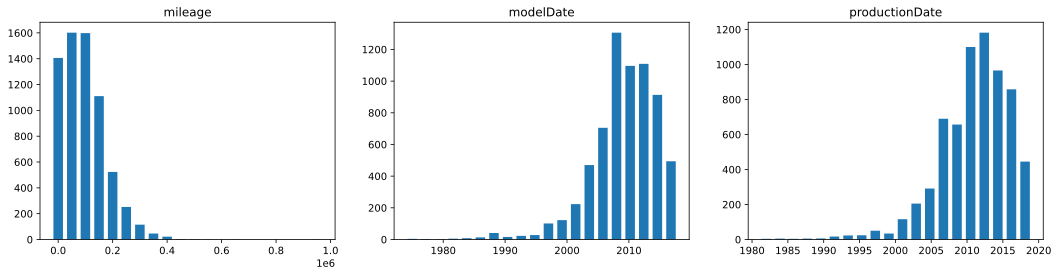

In [6]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# Analize Tabular Data

In [7]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [8]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [9]:
data.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [10]:
# делаем быстрый EDA с помощью pandas_profiling.
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Профайлинг показывает, что сейчас данные нуждаются в обработке и среди них много высоко коррелирующих.

# Исследование целевого признака

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


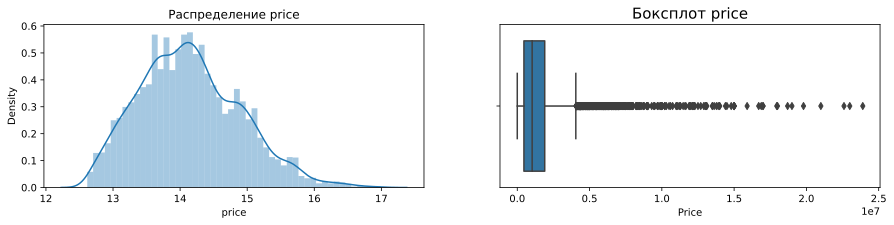

count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

In [11]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение {'price'}")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Боксплот {'price'}", fontsize=15)
plt.show()
data.price.describe()

Выбросы есть, их много. Сократить их количество поможет логарифмизация

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


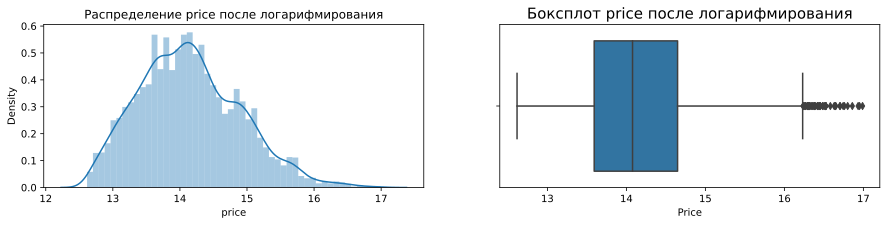

In [12]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title(f"Распределение {'price'} после логарифмирования")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Боксплот price после логарифмирования', fontsize=15)
plt.show()

**Корреляция признаков**

<AxesSubplot:>

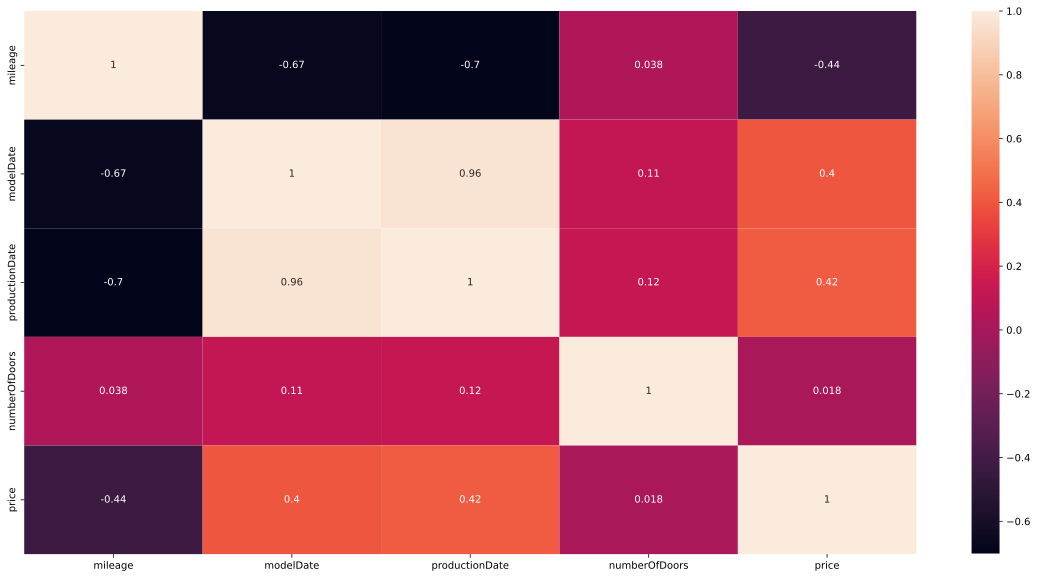

In [13]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[numerical_features+categorical_features+['price']].corr(), annot=True)

Посмотрим поближе на корреляцию. Всего два признака с высокой корреляцией - modelDate и productionDate.

In [14]:
data.nunique()
    

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 180
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
dtype: int64

Для правильной работы модели нужно сократить размерность категориальных признаков.

**Числовые признаки**

Исследуем признаки, которые мы выделили в числовые (впоследствии, возможно, их список увеличится, а часть превратится в категориальные)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


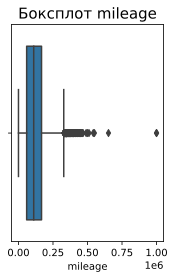

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


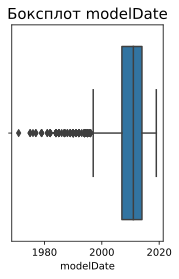

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


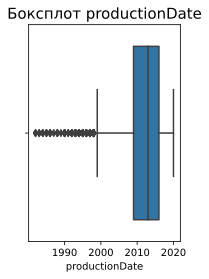

In [15]:
for col in numerical_features:
    plt.subplot(1, 2, 2)
    sns.boxplot(data[col])
    plt.xlabel(col)
    plt.title(f"Боксплот {col}", fontsize=15)
    plt.show()
    data[col].describe()

В числовых данных есть выбросы, поэтому признаки придется обрабатывать и логарифмировать при подаче в модель.

Text(0.5, 1.0, 'Значимость числовых признаков')

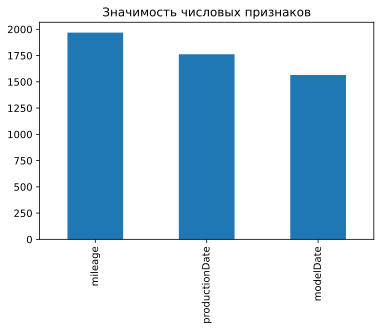

In [16]:
from sklearn.feature_selection import f_regression

imp_num = pd.Series(f_regression(data[numerical_features], data["price"])[0], index=numerical_features)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

Все изначальные признаки важны для модели.

**Категориальные данные**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

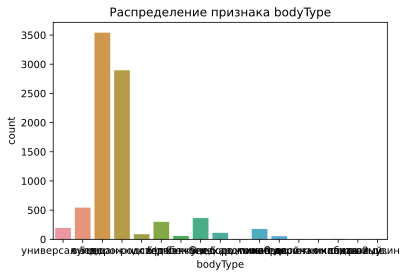

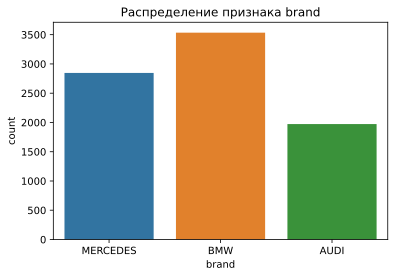

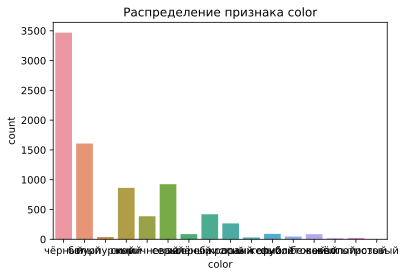

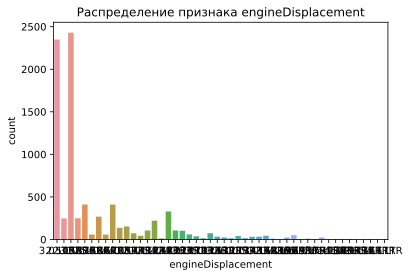

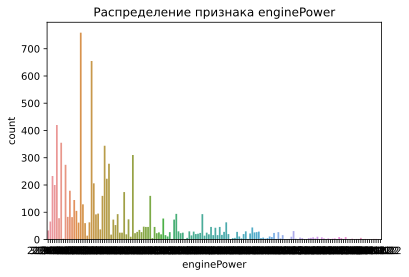

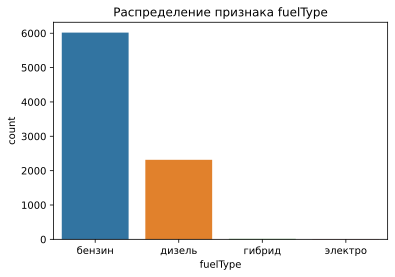

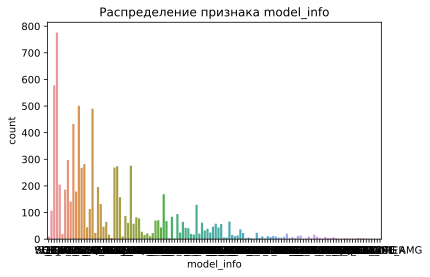

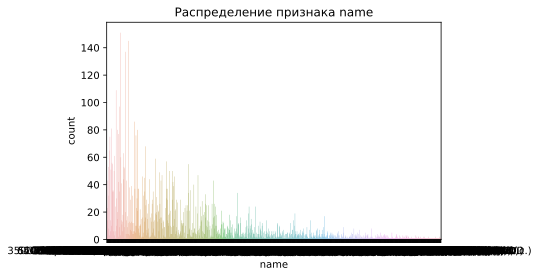

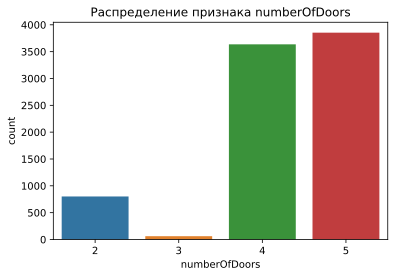

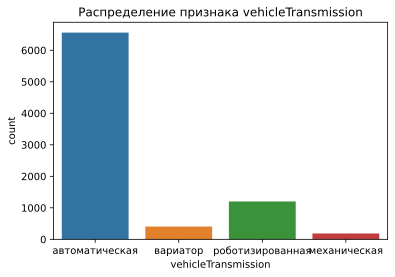

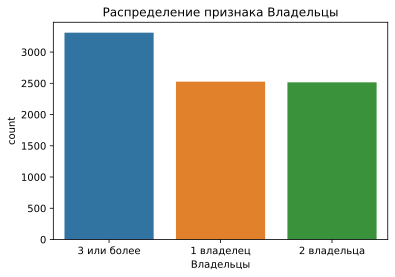

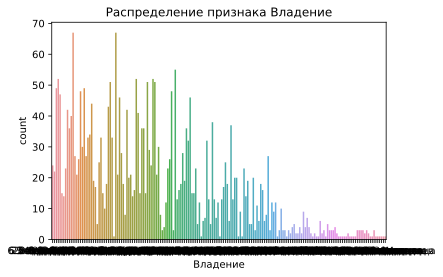

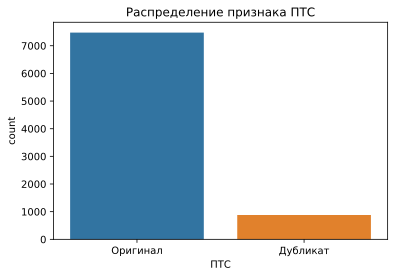

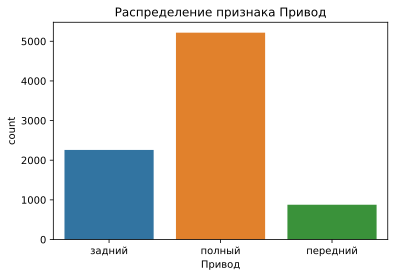

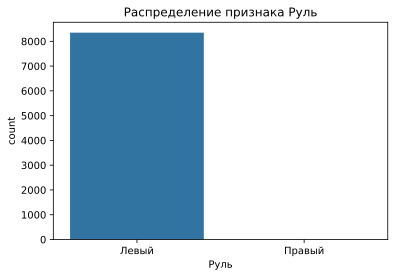

In [17]:
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data[col])
    plt.title(f"Распределение признака {col}")

Для того, чтобы изучить значимость категориальных признаков для модели, надо их предварительно провести label encoding (заменить строки соответствующими числовыми значениями)

In [18]:
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes

<AxesSubplot:>

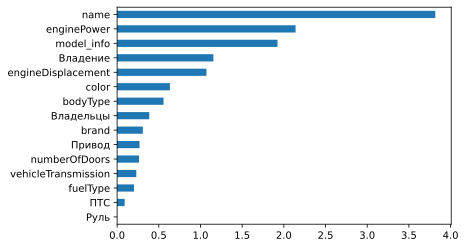

In [19]:
from sklearn.feature_selection import mutual_info_classif

temp_df = data[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[categorical_features],
                                     temp_df['price'], discrete_features=True),
                 index=categorical_features)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Признак "Руль" кажется несущественным и на цену не влияющим.

В основном файле мы рассмотрим эти признаки еще раз. Из некоторых, скорее всего, получится сделать новые.